<a href="https://colab.research.google.com/github/BGDNick/Certified_Robustnenss/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms.functional import to_pil_image, to_tensor
import colorsys
from sklearn.metrics import f1_score
import PIL
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.estimators.classification import PyTorchClassifier

## Natural Shifts (Color shift, Hue shift, SV shift)

In [5]:
def plot_image(image):
    image = image.detach().cpu()
    image = np.transpose(image, (1,2,0))

    plt.imshow(image)
    plt.axis('off')
    plt.show()

def plot_images(images, figsize=(10, 10)):
    """
    Visualizes a batch of images stored as a torch tensor.
    Args:
        images (torch.Tensor): Batch of images with shape (batch_size, channels, height, width).
        figsize (tuple): Size of the figure (width, height) in inches. Default is (10, 10).
    """
    images = images.detach().cpu()  # Detach from computational graph and move to CPU
    images = np.transpose(images, (0, 2, 3, 1))  # Transpose to (batch_size, height, width, channels)

    batch_size = images.shape[0]
    rows = int(np.ceil(np.sqrt(batch_size)))
    cols = int(np.ceil(batch_size / rows))

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.subplots_adjust(hspace=0.3)

    for i, ax in enumerate(axes.flatten()):
        if i < batch_size:
            ax.imshow(images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

In [6]:
def rgb2hsv(image):
    '''
    Support function to change image from rgb format to hsv
    image - torch tensor of rgb image
    '''
    pil_image = to_pil_image(image)
    pil_image = pil_image.convert('HSV')
    return to_tensor(pil_image)

def hsv2rgb(image):
    '''
    Support function to change image from hsv format to rgb
    image - torch array
    '''
    image = image.numpy()
    image = np.transpose(image, (1,2,0)) * 255
    pil_image = Image.fromarray(image.astype(np.uint8), mode='HSV').convert('RGB')
    return to_tensor(pil_image)

def color_shift(image, sigma):
    '''
    Shifts images colors depending on theta
    image - torch tensor of rgb image
    sigma - float
    returns torch image in rgb format with shifted colors
    '''

    powers = torch.tensor([2**(sigma * torch.randn(1)) for i in range(3)], dtype=torch.float32)
    norm = torch.max(powers)
    for ind, layer in enumerate(image):
        image[ind] = image[ind] * powers[ind] / norm

    return image

def sv_shift(image, sigma):
    '''
    image - torch image in rgb format
    sigma - float
    returns torch image in rgb format with shifted saturation and brightness
    '''
    powers = torch.tensor([2 **(sigma * torch.randn(1)) for i in range(2)])
    image = rgb2hsv(image)
    # channel 0 does not changes, since in the papaer it was unchanged
    s_mean = torch.mean(image[1])
    v_mean = torch.mean(image[2])
    s_max = torch.max(image[1])
    v_max = torch.max(image[2])

    all_max = torch.max(torch.tensor([s_max + (powers[0] - 1) * s_mean,
                                      v_max + (powers[1] - 1) * v_mean]))
    image[1] = (image[1] + (powers[0] - 1) * s_mean) / all_max
    image[2] = (image[2] + (powers[1] - 1) * v_mean) / all_max

    return hsv2rgb(image)

def hue_shift(image, sigma):
    '''
    image - torch image in rgb format
    sigma - float
    reutrns - torch image in rgb foramt with shifted hue
    '''
    angle = 2 * torch.pi * sigma * ((2 * torch.rand(1)) - 1) / 360
    image = rgb2hsv(image)
    image[0] = image[0] + angle
    image[0] = image[0] - (2 * torch.pi * torch.floor(image[0] / (2 * torch.pi)))
    return hsv2rgb(image)

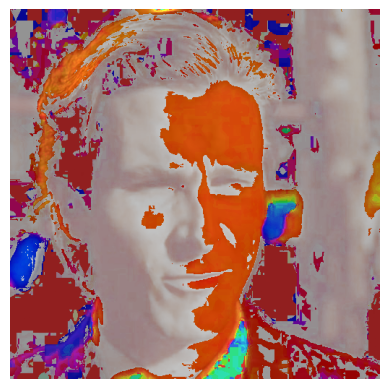

In [7]:
image = Image.open('sigma.jpg')
transform = transforms.Compose([transforms.ToTensor()])
image = Image.open('sigma.jpg')
image = transform(image)
theta = torch.tensor([0,2], dtype=torch.float32)
theta = torch.tensor(torch.pi /2)

plot_image(sv_shift(image, 2))

# Notes on how Wasserstain distance is being computed in the article.

First of radius is being initialized. The radius is equal to Wasserstain distance between two distributions. Details on how these formulas are derived is in the [article](https://arxiv.org/pdf/2201.12440.pdf)

Next $\sigma$ is computed as follows:

* For color shift
$ \sigma = \frac{(\sqrt \pi r)}{2 \sqrt 2}$
* For hue shift $ \sigma = 2r$
* For sv shift $ \sigma = 2r$

Next $\sigma$ is being passed in shift funcitons as hyperparameter.

In [8]:
# Load the model
device = 'cuda'

model = models.resnet34(pretrained=True)
in_features = 512
out_features = 10
model.fc = torch.nn.Linear(in_features, out_features)
model.to(device)
None

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 180MB/s]


In [9]:
# Load the dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 170498071/170498071 [00:02<00:00, 72647024.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs, n_update):
    train_losses = []
    val_losses = []
    f1_scores = []
    steps = 0

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            steps += 1
            if steps % n_update == 0:
                train_losses.append(running_loss / n_update)
                running_loss = 0.0

                model.eval()
                val_loss = 0.0
                val_predictions = []
                val_targets = []

                with torch.no_grad():
                    for val_data, val_target in val_loader:
                        val_data, val_target = val_data.to(device), val_target.to(device)
                        val_output = model(val_data)
                        val_loss += criterion(val_output, val_target).item()

                        val_predictions.extend(torch.argmax(val_output, dim=1).cpu().numpy())
                        val_targets.extend(val_target.cpu().numpy())

                val_loss /= len(val_loader)
                val_f1 = f1_score(val_targets, val_predictions, average='macro')
                val_losses.append(val_loss)
                f1_scores.append(val_f1)

                print(f"Epoch {epoch}/{n_epochs} | Step {steps} | "
                      f"Train Loss: {train_losses[-1]:.4f} | "
                      f"Val Loss: {val_losses[-1]:.4f} | "
                      f"F1 Score: {f1_scores[-1]:.4f}")

        # Plotting
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(f1_scores) + 1), f1_scores, label='F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [12]:
#train_model(model, trainloader, testloader, criterion, optimizer, device='cuda', n_epochs=10, n_update=100)
#torch.save(model.state_dict(), 'drive/MyDrive/Programming/resnet34_cifar')
# Link to the model https://drive.google.com/file/d/1ssdkhJ2KL8tj_38fOzbAP5KNUZflbR7D/view?usp=sharing
model.load_state_dict(torch.load('drive/MyDrive/Programming/resnet34_cifar'))

<All keys matched successfully>

In [13]:
def sertified_accuracy(model, attack_type, bound, alpha=0.95, verbose=False):
    device = 'cuda'
    if attack_type=='color':
        sigma= torch.pi**(1/2) * bound / 2 **(3/2)
        transform = transforms.Lambda(lambda x: color_shift(x, sigma))
    elif attack_type=='hue':
        sigma = 2 * bound
        transform = transforms.Lambda(lambda x: hue_shift(x, sigma))
    elif attack_type=='sv':
        sigma = 2 * bound
        transform = transforms.Lambda(lambda x: sv_shift(x, sigma))
    else:
        print('Unrecognized attack')
        return -1

    base_transform = transforms.Compose([
        transforms.ToTensor(),
        transform,
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5, 0.5, 0.5))
    ])
    test_set = datasets.CIFAR10(root='./data', train=False, transform=base_transform, download=True)
    test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    lower_bound = proportion_confint(correct, total, alpha=2*alpha, method='beta')[1]
    if verbose:
        print(f'Lower bound {lower_bound:.3f} Accuracy of the model {accuracy:.3f}')
    return lower_bound

In [16]:
wasserstain_dist = np.arange(0, 1, 0.1)

In [17]:
 color_sa = []
 for w_dist in tqdm(wasserstain_dist):
    color_sa.append(sertified_accuracy(model, 'color', w_dist, 0.99))

  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified



 10%|█         | 1/10 [00:09<01:27,  9.68s/it]

Files already downloaded and verified



 20%|██        | 2/10 [00:18<01:12,  9.01s/it]

Files already downloaded and verified



 30%|███       | 3/10 [00:26<01:01,  8.81s/it]

Files already downloaded and verified



 40%|████      | 4/10 [00:39<01:01, 10.19s/it]

Files already downloaded and verified



 50%|█████     | 5/10 [00:48<00:49, 10.00s/it]

Files already downloaded and verified



 60%|██████    | 6/10 [00:58<00:39,  9.76s/it]

Files already downloaded and verified



 70%|███████   | 7/10 [01:09<00:31, 10.34s/it]

Files already downloaded and verified



 80%|████████  | 8/10 [01:17<00:19,  9.70s/it]

Files already downloaded and verified



 90%|█████████ | 9/10 [01:25<00:09,  9.05s/it]

Files already downloaded and verified



100%|██████████| 10/10 [01:35<00:00,  9.58s/it]


In [18]:
hue_sa = []
for w_dist in tqdm(wasserstain_dist):
    hue_sa.append(sertified_accuracy(model, 'hue', w_dist, 0.99))

  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified



 10%|█         | 1/10 [00:13<02:00, 13.43s/it]

Files already downloaded and verified



 20%|██        | 2/10 [00:26<01:45, 13.21s/it]

Files already downloaded and verified



 30%|███       | 3/10 [00:39<01:30, 12.96s/it]

Files already downloaded and verified



 40%|████      | 4/10 [00:52<01:18, 13.02s/it]

Files already downloaded and verified



 50%|█████     | 5/10 [01:05<01:05, 13.15s/it]

Files already downloaded and verified



 60%|██████    | 6/10 [01:19<00:53, 13.49s/it]

Files already downloaded and verified



 70%|███████   | 7/10 [01:33<00:40, 13.53s/it]

Files already downloaded and verified



 80%|████████  | 8/10 [01:47<00:27, 13.72s/it]

Files already downloaded and verified



 90%|█████████ | 9/10 [02:01<00:13, 13.72s/it]

Files already downloaded and verified



100%|██████████| 10/10 [02:15<00:00, 13.50s/it]


In [19]:
sv_sa = []
for w_dist in tqdm(wasserstain_dist):
    sv_sa.append(sertified_accuracy(model, 'sv', w_dist, 0.99))

  0%|          | 0/10 [00:00<?, ?it/s]

Files already downloaded and verified



 10%|█         | 1/10 [00:16<02:24, 16.02s/it]

Files already downloaded and verified



 20%|██        | 2/10 [00:33<02:14, 16.75s/it]

Files already downloaded and verified



 30%|███       | 3/10 [00:48<01:53, 16.14s/it]

Files already downloaded and verified



 40%|████      | 4/10 [01:04<01:35, 15.92s/it]

Files already downloaded and verified



 50%|█████     | 5/10 [01:20<01:20, 16.05s/it]

Files already downloaded and verified



 60%|██████    | 6/10 [01:51<01:24, 21.02s/it]

Files already downloaded and verified



 70%|███████   | 7/10 [02:06<00:57, 19.16s/it]

Files already downloaded and verified



 80%|████████  | 8/10 [02:22<00:35, 17.99s/it]

Files already downloaded and verified



 90%|█████████ | 9/10 [02:37<00:17, 17.18s/it]

Files already downloaded and verified



100%|██████████| 10/10 [02:52<00:00, 17.25s/it]


Text(0.5, 1.0, 'ResNet34 peromance under color shift')

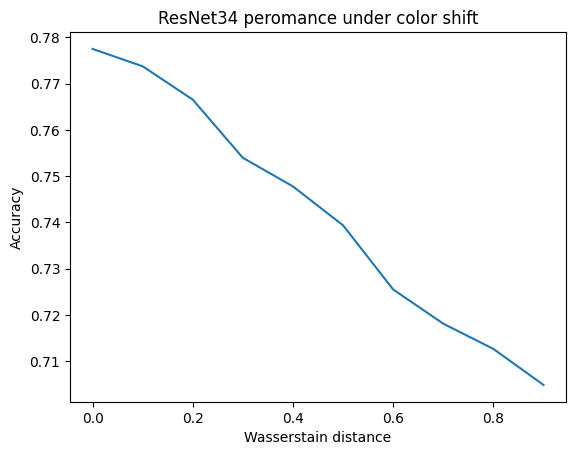

In [25]:
plt.plot(wasserstain_dist, color_sa)
plt.xlabel('Wasserstain distance')
plt.ylabel('Accuracy')
plt.title('ResNet34 peromance under color shift')

Text(0.5, 1.0, 'ResNet34 perfomance under hue shift')

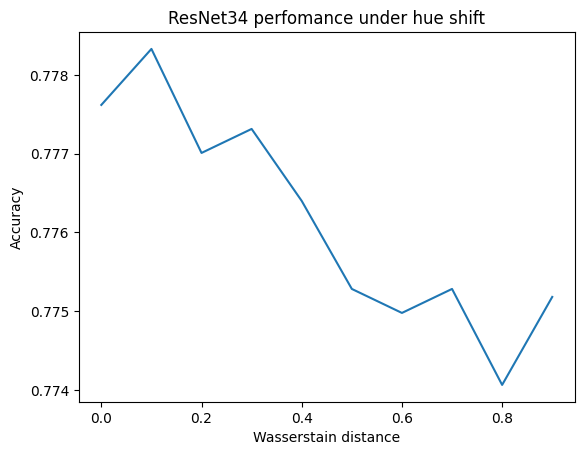

In [26]:
plt.plot(wasserstain_dist, hue_sa)
plt.xlabel('Wasserstain distance')
plt.ylabel('Accuracy')
plt.title('ResNet34 perfomance under hue shift')

Text(0.5, 1.0, 'ResNet34 perfomance under SV shift')

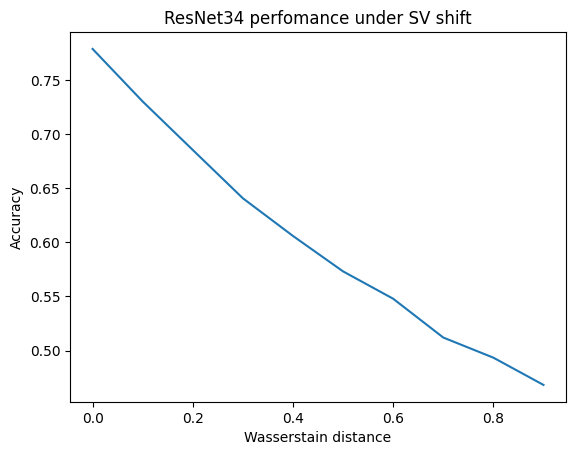

In [27]:
plt.plot(wasserstain_dist, sv_sa)
plt.xlabel('Wasserstain distance')
plt.ylabel('Accuracy')
plt.title('ResNet34 perfomance under SV shift')

# Adversarial attacks on neural network ( Under construction)

## Projected Gradient Descent

In [26]:
testset[0][0].shape

torch.Size([3, 32, 32])

In [28]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0,1),
    loss=criterion,
    preprocessing_defences=None,
    input_shape=(3,32,32),
    nb_classes=10
)

attack = ProjectedGradientDescentPyTorch(
    estimator=classifier,
    norm=2,
    eps=0.2,
    eps_step=0.05,
    max_iter=10
)

In [34]:
correct = 0
all = 0

for image, true_label in tqdm(testset):
    image = image.unsqueeze(0).to('cuda')
    label = np.zeros(10)
    label[true_label] = 1
    true_label = true_label.unsqueeze(0).to('cuda')
    adv_image = attack.generate(x=image, y=true_label)
    pred = classifier.predict(image)
    adv_pred = classifier.predict(adv_image)
    correct += (pred == adv_pred)
    all += 1

  0%|          | 0/10000 [00:00<?, ?it/s]


AttributeError: ignored